# Imports

In [1]:
%matplotlib inline
%config IPCompleter.greedy = True
%config IPCompleter.merge_completions = True
%config IPCompleter.limit_to__all__ = False
import matplotlib
import numpy as np
from numpy import genfromtxt

import scipy.misc
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import csv
import pickle

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

import cv2
import time
import matplotlib.image as mpimg
from scipy.misc import *

Using gpu device 0: GeForce GTX 660M (CNMeM is disabled, cuDNN 5105)
Using Theano backend.


In [2]:
CHANNELS_NUM = 1
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
CLASSES_NUM = 10
EPOCHS_NUM = 20
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
REG = 0.0001
DATASET_SIZE = 42000
TEST_SIZE = 28000
DATA_LOCATION = "MNIST/train.csv"
TEST_LOCATION = "MNIST/test.csv"

# Data Loading

In [3]:
def Load_MNIST_Training():
    X_data = np.zeros((DATASET_SIZE, IMAGE_HEIGHT*IMAGE_WIDTH))
    Y_data = np.zeros((DATASET_SIZE,))
    i = 0
    with open(DATA_LOCATION, 'rb') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            for j in xrange(IMAGE_WIDTH * IMAGE_HEIGHT):
                X_data[i, j] = np.fromstring(row['pixel'+str(j)], dtype=int, sep=',')
            Y_data[i] = row['label']
            i = i + 1
    return X_data, Y_data
X_data,y_data = Load_MNIST_Training()

In [4]:
def Load_MNIST_Test():
    X_test = np.zeros((TEST_SIZE, IMAGE_HEIGHT*IMAGE_WIDTH))
    i = 0
    with open(TEST_LOCATION, 'rb') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            for j in xrange(IMAGE_WIDTH * IMAGE_HEIGHT):
                X_test[i, j] = np.fromstring(row['pixel'+str(j)], dtype=int, sep=',')
            i = i + 1
    return X_test
X_test = Load_MNIST_Test()

# Split into validation and training sets

In [28]:
mask = np.random.choice(DATASET_SIZE-1,int(0.15*DATASET_SIZE),replace=False)
X_val = X_data[mask]
y_val = y_data[mask]
X_train = np.delete(X_data,mask,axis=0)
y_train = np.delete(y_data,mask,axis=0)

X_train = X_train.reshape((X_train.shape[0],1,28,28))
X_val = X_val.reshape((X_val.shape[0],1,28,28))
X_test =X_test.reshape((X_test.shape[0],1,28,28))
y_train=np_utils.to_categorical(y_train.astype('uint8'))
y_val=np_utils.to_categorical(y_val.astype('uint8'))

X_data = X_data.reshape((X_data.shape[0],1,28,28))
y_data=np_utils.to_categorical(y_data.astype('uint8'))
print X_data.shape,y_data.shape,X_train.shape,y_train.shape,X_val.shape,y_val.shape

(42000, 1, 28, 28) (42000, 10) (35700, 1, 28, 28) (35700, 10) (6300, 1, 28, 28) (6300, 10)


# Data Visualization

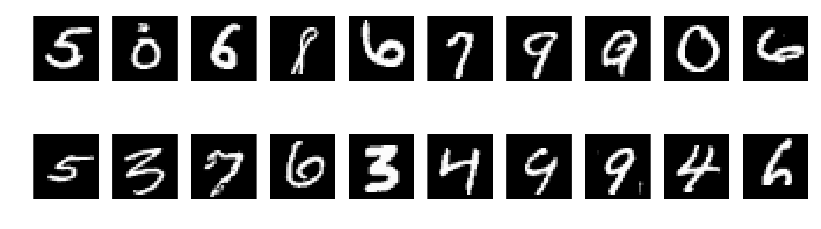

In [83]:
mask = np.random.choice(DATASET_SIZE,200, replace=False)
X_Sample = X_data[mask]
X_Sample = X_Sample.reshape((X_Sample.shape[0],28,28))
    
plt.figure(figsize=(10,15))
for i in xrange(1,21):
    plt.subplot(10,10,i)
    im = X_Sample[i]
    plt.imshow(im, cmap='gray', interpolation='none')
    plt.axis('off')
plt.show()

# Build Model

In [30]:
def BuildModel():
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, init = 'he_normal', input_shape=(1, IMAGE_WIDTH, IMAGE_HEIGHT), border_mode='same', W_regularizer = l2(REG)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(512, init = 'he_normal', W_regularizer = l2(REG)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    
    model.add(Dense(256, init = 'he_normal', W_regularizer = l2(REG)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))   
 
    model.add(Dense(CLASSES_NUM, init = 'he_normal', W_regularizer = l2(REG)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))  
    # Compile model
    adam = Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    #load the model from a saved file
    #model.load_weights("weights.best.hdf5")
    
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    return model

In [31]:
model = BuildModel()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 32, 28, 28)    320         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
batchnormalization_10 (BatchNorm (None, 32, 28, 28)    56          convolution2d_3[0][0]            
____________________________________________________________________________________________________
activation_10 (Activation)       (None, 32, 28, 28)    0           batchnormalization_10[0][0]      
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 25088)         0           activation_10[0][0]              
___________________________________________________________________________________________

# Model Training

In [32]:
try:
    #save the currently best weights.
    #filepath="mnist.weights.best.hdf5"
    #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    #callbacks_list = [checkpoint]
    
    #model.load_weights("mnist.weights.best.hdf5")
    history = model.fit(X_data, y_data, validation_data=None,callbacks = callbacks_list, verbose = 1,shuffle=True, nb_epoch=EPOCHS_NUM, batch_size=BATCH_SIZE)
    #Save the model.
    model.save_weights("model.mnist.weights.h5")

    # list all data in history
    #print(history.history.keys())
    # summarize history for accuracy
    #plt.plot(history.history['acc'])
    #plt.plot(history.history['val_acc'])
    #plt.title('model accuracy')
    #plt.ylabel('accuracy')
    #plt.xlabel('epoch')
    #plt.legend(['train', 'val'], loc='upper left')
    #plt.show()
    # summarize history for loss
    #plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    #plt.title('model loss')
    #plt.ylabel('loss')
    #plt.xlabel('epoch')
    #plt.legend(['train', 'val'], loc='upper left')
    #plt.show()

except KeyboardInterrupt:
    pass

Epoch 1/20
42000/42000 [==============================] - 99s - loss: 0.5365 - acc: 0.9394    
Epoch 2/20
   64/42000 [..............................] - ETA: 99s - loss: 0.3743 - acc: 0.9531

/home/mg/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:287: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


42000/42000 [==============================] - 97s - loss: 0.3121 - acc: 0.9703    
Epoch 3/20
42000/42000 [==============================] - 97s - loss: 0.2464 - acc: 0.9743    
Epoch 4/20
42000/42000 [==============================] - 98s - loss: 0.2206 - acc: 0.9771    
Epoch 5/20
42000/42000 [==============================] - 98s - loss: 0.1984 - acc: 0.9791    
Epoch 6/20
42000/42000 [==============================] - 97s - loss: 0.1784 - acc: 0.9830    
Epoch 7/20
42000/42000 [==============================] - 97s - loss: 0.1680 - acc: 0.9833    
Epoch 8/20
42000/42000 [==============================] - 98s - loss: 0.1573 - acc: 0.9851    
Epoch 9/20
42000/42000 [==============================] - 97s - loss: 0.1404 - acc: 0.9880    
Epoch 10/20
42000/42000 [==============================] - 97s - loss: 0.1341 - acc: 0.9879    
Epoch 11/20
42000/42000 [==============================] - 98s - loss: 0.1215 - acc: 0.9890    
Epoch 12/20
42000/42000 [==============================] - 

# Model Prediction

In [34]:
#load the model.
model.load_weights("model.mnist.weights.h5")
predictions = model.predict(X_test,verbose=1)

28000/28000 [==============================] - 26s    


In [35]:
predictions = np.argmax(predictions, axis=1)

In [36]:
def Output_Predictions():
    X_data = np.zeros((DATASET_SIZE, IMAGE_HEIGHT*IMAGE_WIDTH))
    Y_data = np.zeros((DATASET_SIZE,))

    with open("MNIST/output.csv", 'wb') as csvfile:
        fieldnames = ['ImageId','Label']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in xrange(1,TEST_SIZE+1):
            writer.writerow({'ImageId': str(i), 'Label': predictions[i-1]})
            
Output_Predictions()

Note: I can achieve higher than that with model ensembles.